In [ ]:
!pip install  -q tensorflow
!pip install  -q gradio

## step2: Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


In [ ]:
filenames = os.listdir("/content/drive/MyDrive/fire detection")
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'fire':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [ ]:
!dir   ## to check the file is rar or not

0.jpg	 126.jpg  152.jpg  17.jpg   21.png  36.png  51.jpg  79.jpg
0.png	 127.jpg  153.jpg  17.png   22.jpg  37.jpg  52.jpg  7.jpg
100.jpg  128.jpg  154.jpg  180.jpg  22.png  37.png  53.jpg  7.png
101.jpg  129.jpg  155.jpg  181.jpg  23.jpg  38.jpg  54.jpg  80.jpg
102.jpg  12.jpg   156.jpg  182.jpg  23.png  38.png  55.jpg  81.jpg
103.jpg  12.png   157.jpg  183.jpg  24.jpg  39.jpg  56.jpg  82.jpg
104.jpg  130.jpg  158.jpg  184.jpg  24.png  39.png  57.jpg  83.jpg
105.jpg  131.jpg  159.jpg  185.jpg  25.jpg  3.jpg   58.jpg  84.jpg
106.jpg  132.jpg  15.jpg   186.jpg  25.png  3.png   59.jpg  85.jpg
107.jpg  133.jpg  15.png   187.jpg  26.jpg  40.jpg  5.jpg   86.jpg
108.jpg  134.jpg  160.jpg  188.jpg  26.png  40.png  5.png   87.jpg
109.jpg  135.jpg  161.jpg  189.jpg  27.jpg  41.jpg  60.jpg  88.jpg
10.jpg	 136.jpg  162.jpg  18.jpg   27.png  41.png  61.jpg  89.jpg
10.png	 137.jpg  163.jpg  18.png   28.jpg  42.jpg  62.jpg  8.jpg
110.jpg  138.jpg  164.jpg  190.jpg  28.png  42.png  63.jpg  8.png
111.j

In [ ]:

df.head()

,filename,category
0,87.jpg,0
1,48.jpg,0
2,166.jpg,0
3,184.jpg,0
4,43.jpg,0


In [ ]:
df.tail()

,filename,category
247,39.png,0
248,25.png,0
249,40.png,0
250,28.png,0
251,31.png,0


<Axes: xlabel='category'>

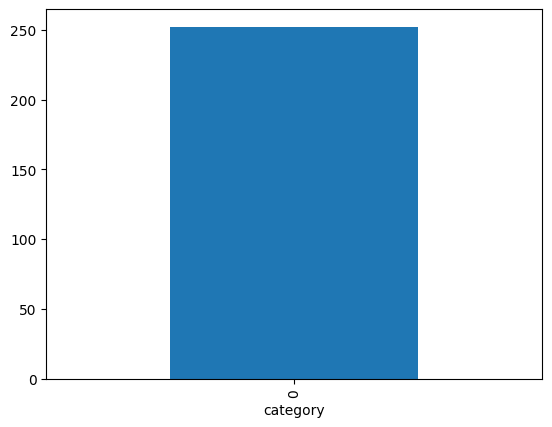

In [ ]:
df['category'].value_counts().plot.bar()

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/fire detection" )
plt.imshow(image)

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/fire detection'

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/fire detection"+sample )
plt.imshow(image)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/fire detection23.png'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape= (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation ='softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer= 'rmsprop', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

## CALLBACKS
# Early Stop
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

## Learning Rate Reduction
# We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:

earlystop = EarlyStopping(patience =10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

## PREPARE DATA
# Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.
## So we will convert 1 to fire and 0 to smoke

In [ ]:
df["category"] = df["category"].replace({0: 'Fire', 1: 'Smoke'})

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

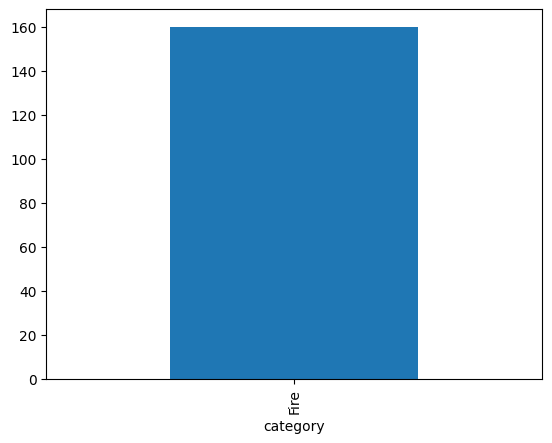

In [ ]:

train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

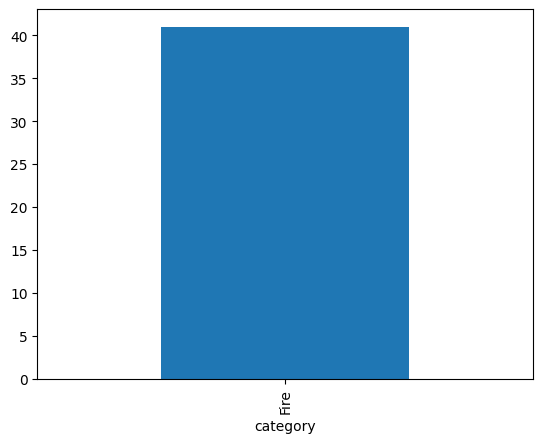

In [ ]:

validate_df['category'].value_counts().plot.bar()


In [ ]:

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size= 15


In [ ]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire/",
    x_col= 'filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size

)


Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 160 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


## VALIDATION GENERATOR

In [ ]:

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 41 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


## SEE HOW GENERATOR WORKS

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'

)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


IndexError: index 0 is out of bounds for axis 0 with size 0

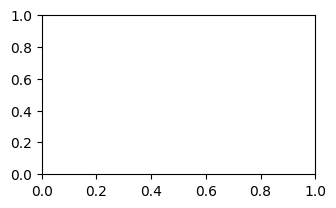

In [ ]:
plt.figure(figsize=(12,12))
for i in range(0,15):
  plt.subplot(5,3, i+1)
  for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

## FIT MODEL

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("fire detection.h5")

<ipython-input-24-cda8e2f8d0f0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


ValueError: Asked to retrieve element 0, but the Sequence has length 0

## VISUALIZE TRAINING

In [ ]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
ax1.plot(history.history['loss'], color ='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color ='r', label="Validation Loss")
ax1.set_xticks(np.arange(1, 11, 1))
ax1.set_yticks(np.arange(0,1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, 11, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## CONFUSION MATRIX

In [ ]:
# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some example data
y_test = [0, 1, 0, 1, 0, 1]  # Example true labels
y_pred = [0, 1, 0, 0, 1, 1]  # Example predicted labels


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## CLASSIFICATION REPORT

In [ ]:
# Calculate and print the Classification Report with zero_division parameter
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(class_report)

In [ ]:
# PREDICTION
result = model.predict(validation_generator,batch_size = batch_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_test = validation_generator.labels

# Evaluvate
loss,acc = model.evaluate(validation_generator, batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
import random


In [ ]:
for i in range(10):
    all_test_images = os.listdir('/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Output/testing')
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Output/testing/{random_image}')
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

    org = img.copy()
    img = img.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

    pred = model.predict(img)
    print(['Fire', 'Smoke'][int(pred[0][0])])
    cv2_imshow(org)
    cv2.waitKey(0)


In [ ]:
!pip install gradio==3.50

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 0.16.1
    Uninstalling gradio_client-0.16.1:
      Successfully uninstalled gradio_client-0.16.1
  Attempting uninstall: gradio
    Found existing installation: gradio 4.29.0
    Uninstalling gradio-4.29.0:
      Successfully uninstalled gradio-4.29.0


In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model


In [ ]:
import os
os.chdir("/content/drive/MyDrive/fire detection")

In [ ]:
!dir


0.jpg	 126.jpg  152.jpg  17.jpg   21.png  36.png  51.jpg  79.jpg
0.png	 127.jpg  153.jpg  17.png   22.jpg  37.jpg  52.jpg  7.jpg
100.jpg  128.jpg  154.jpg  180.jpg  22.png  37.png  53.jpg  7.png
101.jpg  129.jpg  155.jpg  181.jpg  23.jpg  38.jpg  54.jpg  80.jpg
102.jpg  12.jpg   156.jpg  182.jpg  23.png  38.png  55.jpg  81.jpg
103.jpg  12.png   157.jpg  183.jpg  24.jpg  39.jpg  56.jpg  82.jpg
104.jpg  130.jpg  158.jpg  184.jpg  24.png  39.png  57.jpg  83.jpg
105.jpg  131.jpg  159.jpg  185.jpg  25.jpg  3.jpg   58.jpg  84.jpg
106.jpg  132.jpg  15.jpg   186.jpg  25.png  3.png   59.jpg  85.jpg
107.jpg  133.jpg  15.png   187.jpg  26.jpg  40.jpg  5.jpg   86.jpg
108.jpg  134.jpg  160.jpg  188.jpg  26.png  40.png  5.png   87.jpg
109.jpg  135.jpg  161.jpg  189.jpg  27.jpg  41.jpg  60.jpg  88.jpg
10.jpg	 136.jpg  162.jpg  18.jpg   27.png  41.png  61.jpg  89.jpg
10.png	 137.jpg  163.jpg  18.png   28.jpg  42.jpg  62.jpg  8.jpg
110.jpg  138.jpg  164.jpg  190.jpg  28.png  42.png  63.jpg  8.png
111.j

In [ ]:
model = load_model("/content/drive/MyDrive/fire detection")

OSError: SavedModel file does not exist at: /content/drive/MyDrive/fire detection/{saved_model.pbtxt|saved_model.pb}

In [ ]:

model.summary()